In [ ]:
# #only run once
# #!pip install nes-py==0.2.6
# !brew update
# !brew install ffmpeg
# !brew install libsm
# !brew install libxext
# !brew install mesa
# !pip install opencv-python
# !pip install gym-super-mario-bros
# !pip install gym

In [79]:
import torch
import torch.nn as nn
import random
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros import SuperMarioBrosEnv
from tqdm import tqdm
import pickle 
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import time
import datetime
import json

In [7]:
from toolkit.gym_env import *
from toolkit.action_utils import *
from toolkit.marlios_model import *
from toolkit.constants import *

CONSECUTIVE_ACTIONS = 2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    display(plt.gcf(), clear=True)

def make_env(env, actions=ACTION_SPACE):
    env = MaxAndSkipEnv(env, skip=2) # I am testing out fewer fram repetitions for our two actions modelling
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, actions)

def generate_epoch_time_id():
    epoch_time = int(time.time())
    return str(epoch_time)

def save_checkpoint(agent, total_rewards, terminal_info, run_id):
    with open(f"ending_position-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.ending_position, f)
    with open(f"num_in_queue-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.num_in_queue, f)
    with open(f"total_rewards-{run_id}.pkl", "wb") as f:
        pickle.dump(total_rewards, f)
    with open(f"terminal_info-{run_id}.pkl", "wb") as f:
        pickle.dump(terminal_info, f)
    if agent.double_dq:
        torch.save(agent.local_net.state_dict(), f"dq1-{run_id}.pt")
        torch.save(agent.target_net.state_dict(), f"dq2-{run_id}.pt")
    else:
        torch.save(agent.dqn.state_dict(), f"dq-{run_id}.pt")  

def load_rewards(from_file):
     with open(from_file, 'rb') as f:
        total_rewards = pickle.load(f)
        return total_rewards

def plot_rewards(ep_per_stat = 100, total_rewards = [], from_file = None):
    if from_file != None:
        total_rewards = load_rewards(total_rewards)
       
    avg_rewards = [np.mean(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]
    std_rewards = [np.std(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]

    fig, ax = plt.subplots()
    ax.plot(avg_rewards, label='Average Rewards')
    ax.fill_between(range(len(avg_rewards)), np.subtract(avg_rewards, std_rewards), np.add(avg_rewards, std_rewards), alpha=0.2, label='Reward StdDev')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    xtick_labels = [str(i*ep_per_stat) for i in range(len(avg_rewards))]
    plt.xticks(range(len(avg_rewards)), xtick_labels)
    ax.legend(loc='lower right')
    plt.show()

# define the run function with some helpful debugging stats

def run(training_mode=True, pretrained=False, lr=0.0001, gamma=0.90, exploration_decay=0.995, exploration_min=0.02, 
        ep_per_stat = 100, exploration_max = 1,
        mario_env='SuperMarioBros-1-1-v0', action_space=TWO_ACTIONS_SET, num_episodes=1000, run_id=None, n_actions=5):
   
    run_id = run_id or generate_epoch_time_id()
    fh = open(f'progress-{run_id}.txt', 'a')
    env = gym.make(mario_env)
    env = make_env(env, ACTION_SPACE)


    # observation_space = env.observation_space.shape # not using this anymore

    #todo: add agent params as a setting/create different agents in diff functions to run 
    exploration_max = min(1, max(exploration_max, exploration_min))

    agent = DQNAgent(
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=gamma,
                     lr=lr,
                     dropout=0.,
                     exploration_max=exploration_max,
                     exploration_min=exploration_min,
                     exploration_decay=exploration_decay,
                     double_dq=True,
                     pretrained=pretrained,
                     run_id=run_id,
                     n_actions=n_actions)
    
    
    # num_episodes = 10
    env.reset()
    total_rewards = []
    total_info = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()[-1] # take the final dimension of shape (4, 84, 84) leaving shape (84, 84) 
        state = torch.Tensor([state]).unsqueeze(0) # converts (1, 84, 84) to (1, 1, 84, 84)
        total_reward = 0
        steps = 0

        action_freq = {}
        while True:
            if not training_mode:
                show_state(env, ep_num)


            two_actions_index = agent.act(state)
            two_actions_vector = agent.cur_action_space[0, two_actions_index[0]]
            two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions

            # debugging info
            key = " | ".join([",".join(i) for i in two_actions])
            if key in action_freq:
                action_freq[key] += 1
            else:
                action_freq[key] = 1
            
            steps += 1
            reward = 0
            info = None
            terminal = False
            for action in two_actions: 
                if not terminal:
                    # compute index into ACTION_SPACE of our action
                    step_action = ACTION_TO_INDEX[action]

                    state_next, cur_reward, terminal, info = env.step(step_action)
                    total_reward += cur_reward
                    reward += cur_reward
                    
            state_next = torch.Tensor([state_next[-1]]).unsqueeze(0)
            reward = torch.tensor([reward]).unsqueeze(0)        
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, two_actions_index, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break

        total_info.append(info)
        total_rewards.append(total_reward)

        if training_mode and (ep_num % ep_per_stat) == 0:
            save_checkpoint(agent, total_rewards, total_info, run_id)

        with open(f'total_reward-{run_id}.txt', 'a') as f:
            f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
            if (ep_num%100 == 0):
                f.write("==================\n")
                f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
                f.write("==================\n")
            #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
            num_episodes += 1
        
        with open(f'actions_chosen-{run_id}.txt', 'a') as f:
            f.write("Action Frequencies for Episode {}, Exploration = {:4f}\n".format(ep_num + 1, agent.exploration_rate))
            f.write(json.dumps(action_freq) + "\n\n")
    
    if training_mode:
        save_checkpoint(agent, total_rewards, total_info, run_id)
    
    env.close()
    fh.close()
    
    if num_episodes > ep_per_stat:
        plot_rewards(ep_per_stat=ep_per_stat, total_rewards=total_rewards)


In [110]:
run_id = '1681801872'

In [107]:
# rerun with pretrained model:
run(training_mode=True, 
    pretrained=True, # use the pretrained model
    ep_per_stat=100, 
    run_id=run_id,
    lr=0.000005,
    exploration_min=0.1,
    exploration_max = 0.1,
    exploration_decay=0.9995, 
    action_space=SIMPLE_MOVEMENT,
    n_actions=len(SIMPLE_MOVEMENT)+2)

/Users/cameronwitz/Desktop/CSCI_566/env/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/cameronwitz/Desktop/CSCI_566/env/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/cameronwitz/Desktop/CSCI_566/env/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/cameronwitz/Desktop/CSCI_566/env/lib/python3.10/site-packag

KeyboardInterrupt: 

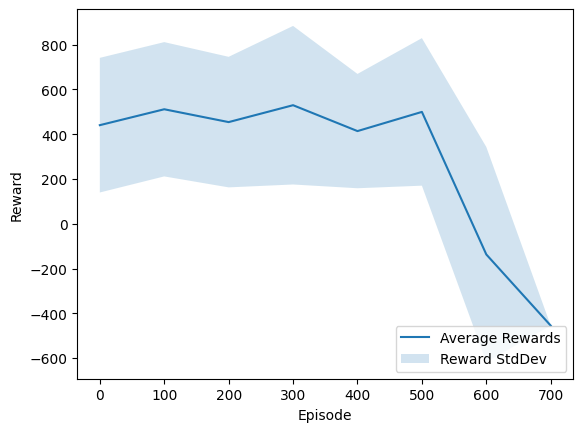

In [121]:
file_name = "total_rewards-{}.pkl".format(run_id)
total_rewards = load_rewards(file_name)

plot_rewards(ep_per_stat=100, total_rewards=total_rewards)

# ep_per_stat = 100  # number of episodes to average over

# Debugging

In [74]:
training_mode=True
pretrained=False
lr=0.000005
gamma=0.90
exploration_decay=0.995
exploration_min=0.02
ep_per_stat = 100
mario_env='SuperMarioBros-1-1-v0'
action_space=SIMPLE_MOVEMENT
num_episodes=1000
run_id=None
n_actions=len(SIMPLE_MOVEMENT) + 2
consecutiveActions = 2

run_id = run_id or generate_epoch_time_id()
fh = open(f'progress-{run_id}.txt', 'a')
env = gym.make(mario_env)
#env = gym_super_mario_bros.make('SuperMarioBros-v0')

#env = make_env(env)  # Wraps the environment so that frames are grayscale 
#env = SuperMarioBrosEnv()
env = make_env(env, ACTION_SPACE)
# observation_space = env.observation_space.shape # not using this anymore

#todo: add agent params as a setting/create different agents in diff functions to run 

agent = DQNAgent(
                    action_space=action_space,
                    max_memory_size=30000,
                    batch_size=64,
                    gamma=gamma,
                    lr=lr,
                    dropout=0.,
                    exploration_max=1,
                    exploration_min=exploration_min,
                    exploration_decay=exploration_decay,
                    double_dq=True,
                    pretrained=pretrained,
                    run_id=run_id,
                    n_actions=n_actions)


# num_episodes = 10
env.reset()
total_rewards = []
total_info = []

for ep_num in tqdm(range(num_episodes)):
    state = env.reset()[-1] # take the final dimension of shape (4, 84, 84) leaving shape (84, 84) 
    state = torch.Tensor([state]).unsqueeze(0) # converts (1, 84, 84) to (1, 1, 84, 84)
    total_reward = 0
    steps = 0
    while True:
        if not training_mode:
            show_state(env, ep_num)


        two_actions_index = agent.act(state)
        # print()
        # print(two_actions_index.float())
        two_actions_vector = agent.cur_action_space[0, two_actions_index[0]]
        # print(two_actions_vector)

        two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions

        if ep_num % 5 == 0 and ep_num != 0:
            print(two_actions)

        steps += 1
        reward = 0
        info = None
        terminal = False
        for action in two_actions: 
            if not terminal:
                # compute index into ACTION_SPACE of our action
                step_action = ACTION_TO_INDEX[action]

                state_next, cur_reward, terminal, info = env.step(step_action)
                total_reward += cur_reward
                reward += cur_reward
                state_next = torch.Tensor([state_next[-1]]).unsqueeze(0)

        reward = torch.tensor([reward]).unsqueeze(0)        
        terminal = torch.tensor([int(terminal)]).unsqueeze(0)
        
        if training_mode:
            agent.remember(state, two_actions_index, reward, state_next, terminal)
            agent.experience_replay()
        
        state = state_next
        if terminal:
            break

    total_info.append(info)
    total_rewards.append(total_reward)

    if training_mode and (ep_num % ep_per_stat) == 0:
        save_checkpoint(agent, total_rewards, total_info, run_id)

    with open(f'total_reward-{run_id}.txt', 'a') as f:
        f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
        if (ep_num%100 == 0):
            f.write("==================\n")
            f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
            f.write("==================\n")
        #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1

if training_mode:
    save_checkpoint(agent, total_rewards, run_id)

env.close()
fh.close()

if num_episodes > ep_per_stat:
    plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
    plt.plot([0 for _ in range(ep_per_stat)] + 
                np.convolve(total_rewards, np.ones((ep_per_stat,))/ep_per_stat, mode="valid").tolist())
    plt.show()



  0%|          | 4/1000 [04:08<17:09:22, 62.01s/it]


KeyboardInterrupt: 

In [57]:
len(SIMPLE_MOVEMENT) + 2

9

In [72]:
agent.cur_action_space.shape
rand_ind = random.randrange(0, agent.cur_action_space.shape[1])


1

In [28]:
print(two_actions_index)
two_actions_vector = agent.cur_action_space[0, two_actions_index]
print(two_actions_vector.shape)
two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions

tensor([6])
torch.Size([1, 10])


ValueError: array split does not result in an equal division

In [34]:
results = agent.local_net(state.to(agent.device), agent.cur_action_space).cpu()
print(results)
torch.argmax(results, dim=1)

tensor([[-0.0211, -0.0230, -0.0210, -0.0221, -0.0215, -0.0214, -0.0200, -0.0203,
         -0.0200]], grad_fn=<ToCopyBackward0>)


tensor([6])

In [ ]:
x = env.reset()[-1] # take the final dimension of shape (4, 84, 84) leaving shape (84, 84) 
x = torch.Tensor([x]).unsqueeze(0).to(agent.device) # converts (1, 84, 84) to (1, 1, 84, 84)
# print(state.shape)

conv_out = agent.local_net.conv(x).view(x.size()[0], -1)
batched_conv_out = conv_out.reshape(conv_out.shape[0], 1, conv_out.shape[-1]).repeat(1, agent.cur_action_space.shape[-2], 1)
batched_actions = torch.cat((batched_conv_out, agent.cur_action_space), dim=2)
intermediate = agent.local_net.fc(batched_actions)
out =  torch.flatten(intermediate, start_dim=1)


In [ ]:
# print(intermediate)

double = torch.cat((intermediate, intermediate + 1))
out = torch.flatten(double, start_dim=1)

In [ ]:
STATE, ACTION, REWARD, STATE2, DONE, SPACE = agent.recall()
STATE = STATE.to(agent.device)
ACTION = ACTION.to(agent.device)
REWARD = REWARD.to(agent.device)
STATE2 = STATE2.to(agent.device)
SPACE = SPACE.to(agent.device)
DONE = DONE.to(agent.device)

agent.optimizer.zero_grad()
# Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)

target = REWARD + torch.mul((agent.gamma * 
                            agent.target_net(STATE2, SPACE).max(1).values.unsqueeze(1)), 
                            1 - DONE)

current = agent.local_net(STATE, SPACE).gather(1, ACTION.long()) # Local net approximation of Q-value


loss = agent.l1(current, target) # maybe we can play with some L2 loss 
loss.backward() # Compute gradients
agent.optimizer.step() # Backpropagate error

# agent.cur_action_space = torch.from_numpy(agent.subsample_actions(agent.n_actions)).to(torch.float32).to(agent.device)
# I am disabling this here for my testing, but also think we should add it to the run loop for testing til we are sure it works, idk

agent.exploration_rate *= agent.exploration_decay

# Makes sure that exploration rate is always at least 'exploration min'
agent.exploration_rate = max(agent.exploration_rate, agent.exploration_min)

In [ ]:
x = STATE
sampled_actions = SPACE

conv_out = agent.local_net.conv(x).view(x.size()[0], -1)
batched_conv_out = conv_out.reshape(conv_out.shape[0], 1, conv_out.shape[-1]).repeat(1, sampled_actions.shape[-2], 1)

# Checking what the model was doing

In [ ]:
training_mode=False
pretrained=True
lr=0.00025
gamma=0.90
exploration_decay=0.995
exploration_min=0.02
ep_per_stat = 100
mario_env='SuperMarioBros-1-1-v0'
action_space=SIMPLE_MOVEMENT
num_episodes=1000
# run_id='1681699251'
n_actions=len(SIMPLE_MOVEMENT) + 2
consecutiveActions = 2

run_id = run_id or generate_epoch_time_id() 
fh = open(f'progress-{run_id}.txt', 'a')
env = gym.make(mario_env)
#env = gym_super_mario_bros.make('SuperMarioBros-v0')

#env = make_env(env)  # Wraps the environment so that frames are grayscale 
#env = SuperMarioBrosEnv()
env = make_env(env, ACTION_SPACE)
# observation_space = env.observation_space.shape # not using this anymore


#todo: add agent params as a setting/create different agents in diff functions to run 

agent = DQNAgent(
                    action_space=action_space,
                    max_memory_size=30000,
                    batch_size=32,
                    gamma=gamma,
                    lr=lr,
                    dropout=0.,
                    exploration_max=.02,
                    exploration_min=exploration_min,
                    exploration_decay=exploration_decay,
                    double_dq=True,
                    pretrained=pretrained,
                    run_id=run_id,
                    n_actions=n_actions)


# num_episodes = 10
env.reset()
total_rewards = []
total_info = []

for ep_num in tqdm(range(num_episodes)):
    state = env.reset()[-1] # take the final dimension of shape (4, 84, 84) leaving shape (84, 84) 
    state = torch.Tensor([state]).unsqueeze(0) # converts (1, 84, 84) to (1, 1, 84, 84)
    total_reward = 0
    steps = 0
    while True:
        # if not training_mode:
            # show_state(env, ep_num)


        two_actions_index = agent.act(state)

        two_actions_vector = agent.cur_action_space[0, two_actions_index]

        two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions
        
        steps += 1
        reward = 0
        info = None
        terminal = False
        for action in two_actions: 
            if not terminal:
                # compute index into ACTION_SPACE of our action
                step_action = ACTION_TO_INDEX[action]

                state_next, cur_reward, terminal, info = env.step(step_action)
                total_reward += cur_reward
                reward += cur_reward

        state_next = torch.Tensor([state_next[-1]]).unsqueeze(0)
        reward = torch.tensor([reward]).unsqueeze(0)        
        terminal = torch.tensor([int(terminal)]).unsqueeze(0)
        
        if training_mode:
            agent.remember(state, two_actions_index, reward, state_next, terminal)
            agent.experience_replay()
        
        state = state_next
        if terminal:
            break

    total_info.append(info)
    total_rewards.append(total_reward)

    if training_mode and (ep_num % ep_per_stat) == 0:
        save_checkpoint(agent, total_rewards, total_info, run_id)

    with open(f'total_reward-{run_id}.txt', 'a') as f:
        f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
        if (ep_num%100 == 0):
            f.write("==================\n")
            f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
            f.write("==================\n")
        #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1

if training_mode:
    save_checkpoint(agent, total_rewards, run_id)

env.close()
fh.close()

if num_episodes > ep_per_stat:
    plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
    plt.plot([0 for _ in range(ep_per_stat)] + 
                np.convolve(total_rewards, np.ones((ep_per_stat,))/ep_per_stat, mode="valid").tolist())
    plt.show()



In [ ]:
for i in range(agent.n_actions):
    two_actions_vector = agent.cur_action_space[0, i]
    two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions
    print(two_actions)

